In [1519]:
import rebound 

import sympy as sp
from matplotlib import pyplot as plt
from matplotlib import pyplot

import numpy as np

from sympy import init_printing
init_printing()

%matplotlib inline
from sympy import *

import math
                        
from scipy import optimize   

In [1520]:
# plot style and colour
plt.style.use('seaborn')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# plot border
plt.rcParams["axes.edgecolor"] = '0'
plt.rcParams["axes.linewidth"] = 0.7

In [1521]:
rad_mas = 206264806.24709466
as_mas = 1000

# Functions

In [1522]:
def cos(x):
  return np.cos(x)

def sin(x):
  return np.sin(x)

def arctan(x):
    return np.arctan(x)

# Predicting an Astrometric signal

In [1523]:
# positions 
pos_sun   , pos_sun_wp    = np.zeros((m,3)) , np.zeros((m,3))          # sun
pos_earth , pos_earth_wp  = np.zeros((m,3)) , np.zeros((m,3))          # earth 
pos_star  , pos_star_wp   = np.zeros((m,3)) , np.zeros((m,3))          # star 
pos_planet_wp             = np.zeros((m,3))                            # planet 

# center of masses  
sun_earth_com , sun_earth_com_wp = np.zeros((m,3)) , np.zeros((m,3))   # sun and earth center of mass
all_com                          = np.zeros((m,3))                     # center of mass of all objects (with and wihtout planet)

# r_star - r_earth vector
r_SE, r_SE_wp = np.zeros((m,3)), np.zeros((m,3))                       # for r_star - r_earth with and without planet
r_SC =  np.zeros((m,3))                                                # for r_star - r_barycentre


# length of vectors in xy-plane  
r_SE_xy, r_SE_xy_wp = np.zeros((m,1)), np.zeros((m,1))                 # r_star - r_earth with and without planet
r_SC_xy = np.zeros((m,1))
r_SC_xyz = np.zeros((m,1))
r_all_com_xy        = np.zeros((m,1))                                  # for r_com (all objects)

# right ascension and declination
alpha         , delta         = np.empty((m,1)) , np.empty((m,1))      # for r_star - r_earth vector without planet 
alpha_wp      , delta_wp      = np.empty((m,1)) , np.empty((m,1))      # for r_star - r_earth vector with planet 
alpha_all_com , delta_all_com = np.zeros((m,1)) , np.zeros((m,1))      # for r_com (all objects)

values = np.zeros((m,3))
proper = np.zeros((m,2))

alpha_SC = np.empty((m,1))
delta_SC = np.empty((m,1))

velocity = np.empty((m,3))

In [1524]:
timescale = 4.2
m         = 200
times     = np.linspace(0,timescale,num=m)

# planet parameters 
planet_inc = 0
m_planet   = 0.0143188

# star parameters 
m_star  = 1                                                 # M_sun
v_star  = 4.74*(50*0.001)*(50)* (1/1.496e+8) * (3.154e+7)   # AU/year
vz_star = 1.7*v_star                                        # AU/year
z_star  = 50*206265                                         # AU

In [1525]:
sim_wp = rebound.Simulation()                                                              # create a simulation named sim_wp 

sim_wp.units = ["msun","AU","year"]                                                        # setting units of sim_wpm

sim_wp.add(m=1)                                                                            # add the Sun as the central object 

sim_wp.add(m=3.0027e-6, a=1, e=0)                                                          # add Earth in a 1 AU circular orbit 

sim_wp.add(x = 1.031e7, vy=v_star, m = m_star, z = z_star, vz=vz_star)                     # add a star 50 pc away with calculated velocity and set parameters

sim_wp.add(m = m_planet, a = 0.6, e = 0.2, primary = sim_wp.particles[2], inc=planet_inc)  # add planet from figure 3.1 caption and have it orbit the star 

In [1526]:
com_particle = sim_wp.calculate_com(first=2,last=4)
ssbc_particle = sim_wp.calculate_com(first=0,last=2)

In [1527]:
sim = rebound.Simulation()                          # create a simulation named sim 

sim.units = ["msun","AU","year"]                    # setting units of sim 

sim.add(m=1)                                        # add the Sun as the central object 

sim.add(m=3.0027e-6, a=1, e=0)                      # add Earth in a 1 AU circular orbit 

sim.add(com_particle)                               # add a particle equivaent to the star-planet barycentre

In [1528]:
for i,t in enumerate(times):
    sim.integrate(t)
    sim_wp.integrate(t)
    
    # positions of sun, earth and star
    pos_sun[i]   , pos_sun_wp[i]     = sim.particles[0].xyz,   sim_wp.particles[0].xyz
    pos_earth[i] , pos_earth_wp[i]   = sim.particles[1].xyz,   sim_wp.particles[1].xyz
    pos_star[i]  , pos_star_wp[i]    = sim.particles[2].xyz,   sim_wp.particles[2].xyz
    pos_planet_wp[i]                 =                         sim_wp.particles[3].xyz
    
    # centre of mass of sun and earth 
    com_sun_earth   , com_sun_earth_wp    = sim.calculate_com(last=2), sim_wp.calculate_com(last=2)
    sun_earth_com[i], sun_earth_com_wp[i] = com_sun_earth.xyz        , com_sun_earth_wp.xyz
    
    # center of mass of all objects
    com_all    =  sim_wp.calculate_com()
    all_com[i] = com_all.xyz
    
    # creating vectors wrt something
    r_SE[i], r_SE_wp[i] = pos_star[i] - pos_earth[i], pos_star_wp[i] - pos_earth_wp[i] # r_star - r_earth
    

    #length of vectors wrt in the x-y-plane 
    r_SE_xy[i] , r_SE_xy_wp[i]  = np.sqrt(r_SE[i,0]**2 + r_SE[i,1]**2)      , np.sqrt(r_SE_wp[i,0]**2 + r_SE_wp[i,1]**2) # r_star
    r_all_com_xy[i]             = np.sqrt(all_com[i,0]**2+all_com[i,1]**2) 

    
    # calculating RA and Dec in mas
    alpha[i], alpha_wp[i] = arctan((r_SE[i,1]/r_SE[i,0])),   arctan((r_SE_wp[i,1]/r_SE_wp[i,0])) 
    delta[i], delta_wp[i] = arctan((r_SE[i,2]/r_SE_xy[i])) , arctan((r_SE_wp[i,2]/r_SE_xy_wp[i]))
    
    alpha_all_com[i] = np.arctan2(all_com[i,1], all_com[i,0])     
    delta_all_com[i] = np.arctan2(all_com[i,2], r_all_com_xy[i,0]) 
  
    com_particle = sim_wp.calculate_com(first=2,last=4)
    ssbc_particle = sim_wp.calculate_com(first=0,last=2)
    
    r_SC[i]    = np.array(com_particle.xyz) - np.array(ssbc_particle.xyz)
    r_SC_xy[i] = np.sqrt(r_SC[i,0]**2+r_SC[i,1]**2)
    
    alpha_SC[i] = np.arctan2(r_SC[i,1] ,r_SC[i,0])     
    delta_SC[i] = np.arctan2(r_SC[i,2],r_SC_xy[i,0])
    
    r_SC_xyz[i] = np.sqrt(r_SC[i,0]**2 + r_SC[i,1]**2+ r_SC[i,2]**2)
        
    # distance to the star wrt barycentre
    d = r_SC_xyz[i]
    
    # velocity of star 
    velocity[i] = np.array(com_particle.vxyz) - np.array(ssbc_particle.vxyz)
    vx, vy, vz = velocity[i,0], velocity[i,1], velocity[i,2]

    sina = sin(alpha_SC[i])
    cosa = cos(alpha_SC[i])
    
    sind = sin(delta_SC[i])
    cosd = cos(delta_SC[i])
     
    values[i,0] =   vx * cosa * cosd      +  vy * sina * cosd     +  vz * sind
    values[i,1] = -(vx * sina)/(d * cosd) + (vy * cosa)/(d*cosd)
    values[i,2] = -(vx * sind * cosa)/d   - (vy * sina * sind)/d  + (vz * cosd)/d
    
    proper[i,0] = values[i,1]
    proper[i,1] = values[i,2]


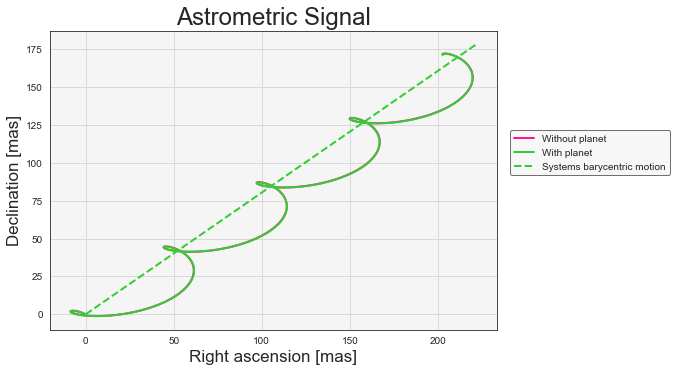

In [1529]:
# plotting data 
plt.plot(alpha*rad_mas,         
         (delta-delta[0])*rad_mas,                 
         color='deeppink',
         lw=2, 
         label='Without planet')

plt.plot(alpha_wp*rad_mas,      
         (delta_wp-delta_wp[0])*rad_mas,           
         color='limegreen', 
         lw=2, 
         label='With planet')

plt.plot(alpha_all_com*rad_mas, 
         (delta_all_com-delta_all_com[0])*rad_mas, 
         color='limegreen',      
         lw=2, 
         ls='--',
         label='Systems barycentric motion')

#plt.plot(x, y, label='From plot', color='black',ls='--')

# set titles 
plt.title('Astrometric Signal'     , fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.4, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

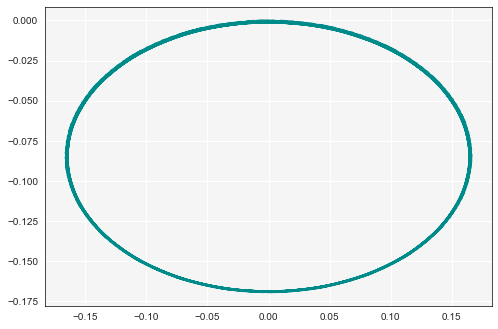

In [1530]:
plt.plot((alpha_wp-alpha)*rad_mas, ((delta_wp-delta_wp[0])-(delta-delta[0]))*rad_mas, color='darkcyan',linewidth=2, markersize=12, label='Difference')

<span style="color:blue"> 
    values $=
\begin{bmatrix}
\dot{d}(t_0) & \dot{\alpha}(t_0) & \dot{\delta}(t_0) \\
\dot{d}(t_1) & \dot{\alpha}(t_1) & \dot{\delta}(t_1) \\
\dot{d}(t_2) & \dot{\alpha}(t_2) & \dot{\delta}(t_2) \\
... &. .. & ... \\
\dot{d}(t_m) & \dot{\alpha}(t_m) & \dot{\delta}(t_m) \end{bmatrix}$ 


$\mu_\alpha = \dot{\alpha}\cos\delta-\alpha\dot{\delta}\sin\delta\\$
$\mu_\delta=\dot{\delta}$</span> 

In [1531]:
# plt.plot(times, alpha_SC[:,0]+alpha_SC[0,0], color='green')
# plt.plot(times, proper[0,0]*times, color='red', ls='--')

In [1532]:
# plt.plot(times, delta_SC[:,0], color='green')
# plt.plot(times, proper[0,1]*times+delta_SC[0,0], color='red', ls='--')

In [1533]:
# # plotting data 
# plt.plot(proper[:,0]* 206264806.24709466 ,   proper[:,1]* 206264806.24709466 ,  color = 'red',    lw=2, markersize=12, label='Matrix calculation')

# # set titles 
# plt.title('Plot'     , fontsize = 24)             
# plt.xlabel('Proper motion Right ascension []', fontsize = 17)                     
# plt.ylabel('proper motion Declination []'    , fontsize = 17)
  
# # plot grid
# plt.grid(color='0.85')
# plt.minorticks_on() 

# # plot legend
# legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.35, 0.5))
# legend.get_frame().set_edgecolor('0.3')
# legend.get_frame().set_linewidth(1)

# Reproducing astrometric signal using equations 3.22 and 3.23

In [1534]:
M                 = np.zeros((m,1))
E                 = np.zeros((m,1))
X                 = np.zeros((m,1))
Y                 = np.zeros((m,1))
PI                = np.zeros((m,2))
sum_elements      = np.zeros((m,2))
three22           = np.zeros((m,1))
three23           = np.zeros((m,1))
barycentic_motion = np.zeros((m,2))
parallax_motion   = np.zeros((m,2))
r                 = np.zeros((m,3))
parallax          = np.zeros((m,1))

In [1535]:
tau        = 0                                                 # time of pericentre passage                [years]
t0         = 0                                                 # wrt Julian date                           [years]

a_AU   = 0.6                                                   # semi-major axis                           [AU]
e      = 0.2                                                   # ellipticity of the orbit                  [unitless]
omega  = 0                                                     # argument of perihelion                    [rad] 
OMEGA  = 0                                                     # longitude of the ascending node           [rad]
i      = planet_inc                                            # orbital inclination                       [rad]

alpha1 = alpha_SC[0]                                            #                                          [rad]
delta1 = delta_SC[0]                                            #                                          [rad]

change_RA_0  = values[0,1]                                      # change in RA at time t_0                 [as]
change_DEC_0 = values[0,2]                                      # change in DEC at time t_0                [as]

#parallax = 1/50                                                 # parallax of the system                   [as]

P = a_AU**(3/2)                                                 # period of the system                     [years]
a_as = ((parallax*m_planet)**3*(P/(m_star+m_planet))**2)**(1/3) # semi-major axis                          [as]

proper_motion = 0.05 

xdata     = alpha_all_com*rad_mas
ydata     = (delta_all_com-delta_all_com[0])*rad_mas

theta     = arctan((xdata[m-1]-xdata[0])/(ydata[m-1]-ydata[0])) # angle between prop motion.               [rad]
prop_RA   = proper_motion*sin(theta_1)              # proper motion in RA direction            [as/year]
prop_DEC  = proper_motion*cos(theta_1)                          # proper motion in DEC direction           [as/year]

In [1536]:
A = a_as * (  cos(omega) * cos(OMEGA) - sin(omega) * sin(OMEGA) * cos(i))
B = a_as * (  cos(omega) * sin(OMEGA) + sin(omega) * cos(OMEGA) * cos(i))
F = a_as * (- sin(omega) * cos(OMEGA) - cos(omega) * sin(OMEGA) * cos(i))
G = a_as * (- sin(omega) * sin(OMEGA) + cos(omega) * cos(OMEGA) * cos(i))

#### Calculate:
- mean anomaly $M$ using the equation: $M=\frac{2\pi}{T}(t-\tau)=\frac{2\pi}{a^{3/2}}(t-\tau)$ (Exoplanet handbook 2.9) 
- Eccentric anomaly $E$ using rebound
- elliptical rectangular coordinates  using the equations $X=\cos(E(t))-e$ and $Y=\sqrt{(1-e^2)}\sin(E(t))$ (Exoplanet handbook equations 3.21)
- Orthogonal components of the displacements due to parallax using equation 3.24 from the Exoplanet handbook: $\Pi_{\alpha,t}=r_x(t)\sin\alpha-r_y(t)\cos\alpha$ and $\Pi_{\beta,t}=\left[r_x(t)\cos\alpha+r_y\sin\alpha\right]\sin\delta-r_z(t)\cos\delta$
- the sum part of equations 3.22 and 3.23 from the Exoplanet handbook: $BX_t+GY_t$ and $AX_t+FY_t$

In [1537]:
k = 0
for k, t in enumerate(times):
    sim_wp.integrate(t)
    r[k] = sim_wp.particles[1].xyz
    M[k] = (2*np.pi/a_AU**(3/2))*(t - tau)
    E[k] = rebound.M_to_E(e,M[k]) 
    X[k] = cos(E[k]) - e
    Y[k] = np.sqrt(1-e**2) * sin(E[k])
    PI[k,0] =  r[k,0] * sin(alpha1) - r[k,1] * cos(alpha1)
    PI[k,1] = (r[k,0] * cos(alpha1) + r[k,1] * sin(alpha1)) * sin(delta1) - r[k,2] #* cos(delta1)
    sum_elements[k,0] = B*X[k] + G*Y[k]
    sum_elements[k,1] = A*X[k] + F*Y[k]
    sum_alpha = np.sum(sum_elements[:,0])
    sum_delta = np.sum(sum_elements[:,1]) 
    parallax[k] = 1/r_SE_xy_wp[i]

### The final equations we are calculating are:
- 3.22: $\Delta\alpha(t)\cos\delta=\left[BX_t+GY_t\right]+ \Delta\alpha_0\cos\delta+\varpi\Pi_{\alpha,t}+\mu_\alpha(t-t_0)$
- 3.23: $\Delta\delta(t)=\left[AX_t+F_t\right]+\Delta\delta_0+\varpi\Pi_{\alpha,t}+\mu_\delta(t-t_0)$

In [1538]:
for d,t in enumerate(times):
    three22[d] = (sum_alpha + change_RA_0   + parallax[d] * PI[d,0] + prop_RA  * (t - t0))/cos(delta1)
    three23[d] = (sum_delta + change_DEC_0  + parallax[d] * PI[d,1] + prop_DEC * (t - t0))/cos(delta1)
    
    barycentic_motion[d,0] = (change_RA_0  + prop_RA  * (t - t0))/cos(delta1)                                    
    barycentic_motion[d,1] = (change_DEC_0 + prop_DEC * (t - t0))/cos(delta1)
    
    parallax_motion[d,0] = (parallax[d] * PI[d,0] + prop_RA  * (t - t0)) /cos(delta1)             
    parallax_motion[d,1] = (parallax[d] * PI[d,1] + prop_DEC * (t - t0))  /cos(delta1)                     

# Comparing proper motion

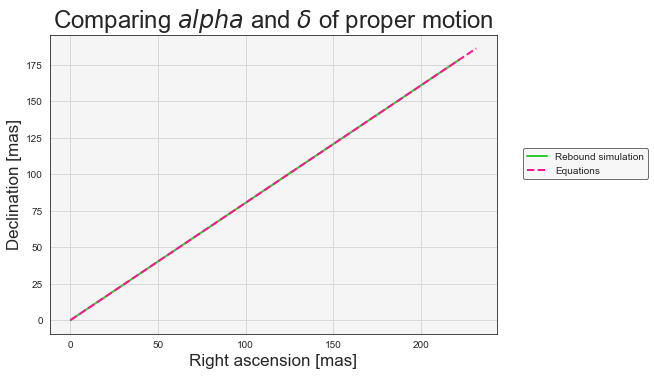

In [1539]:
# plotting data 
plt.plot(rad_mas*alpha_all_com, 
         rad_mas*(delta_all_com-delta_all_com[0]), 
         color='limegreen',
         lw=2, 
         label='Rebound simulation') 

plt.plot(barycentic_motion[:,0]*as_mas  , 
         barycentic_motion[:,1]*as_mas  , 
         color='deeppink', 
         lw=2,
         ls='--', 
         label = 'Equations')

# set titles 
plt.title('Comparing $alpha$ and $\delta$ of proper motion', fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.35, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

# Comparing parallax motion

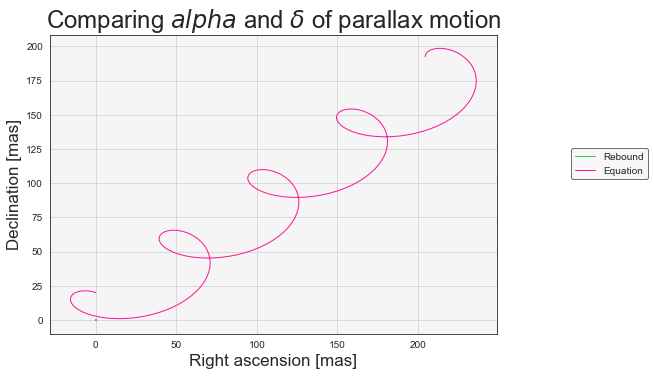

In [1540]:
# plotting data 

plt.plot((alpha_wp-alpha)*rad_mas, 
         ((delta_wp-delta_wp[0])-(delta-delta[0]))*rad_mas, 
         color='limegreen',
         linewidth=1, 
         label='Rebound')

plt.plot(parallax_motion[:,0]*as_mas, 
         parallax_motion[:,1]*as_mas, 
         color='deeppink', 
         lw=1, 
         label = 'Equation')

# set titles 
plt.title('Comparing $alpha$ and $\delta$ of parallax motion', fontsize = 24)             
plt.xlabel('Right ascension [mas]' , fontsize = 17)                     
plt.ylabel('Declination [mas]'     , fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.35, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

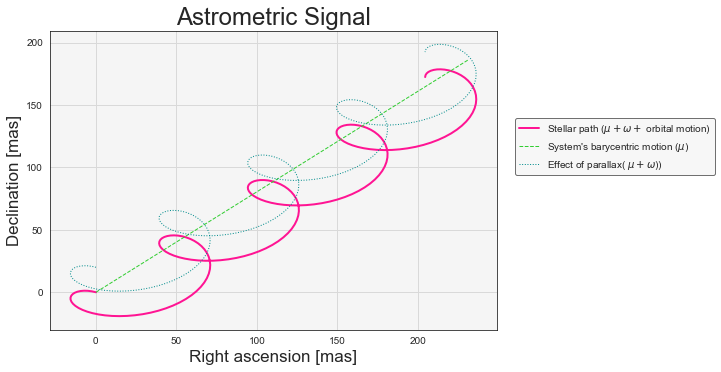

In [1541]:
plt.plot(three22*as_mas, 
         (three23-three23[0])*as_mas, 
         color='deeppink', 
         lw=2,
         label = 'Stellar path ($\mu + \omega +$ orbital motion)')

plt.plot(barycentic_motion[:,0]*as_mas, 
         barycentic_motion[:,1]*as_mas, 
         color='limegreen', 
         lw=1,           
         ls='--', 
         label = 'System\'s barycentric motion ($\mu$)')

plt.plot(parallax_motion[:,0]*as_mas, 
         parallax_motion[:,1]*as_mas, 
         color='darkcyan', 
         lw=1, 
         ls='dotted', 
         label = 'Effect of parallax( $\mu + \omega $))')

#plt.plot(x, y, label='Actual (from figure)', color='black',ls='--',)

# set titles 
plt.title('Astrometric Signal'    , fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)

# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.5, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

# Comparing methods

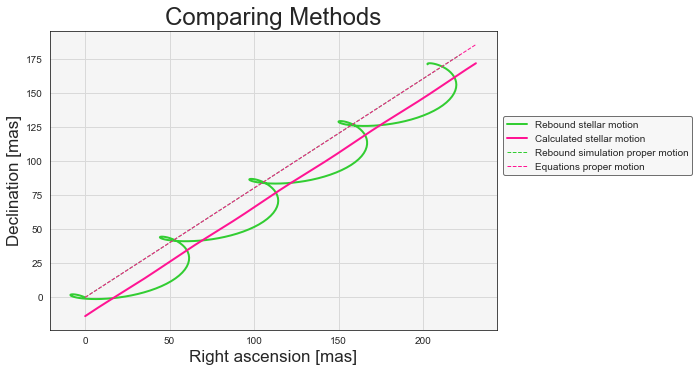

In [1518]:
# plotting data 
plt.plot(alpha_wp*rad_mas, 
         (delta_wp-delta_wp[0])*rad_mas, 
         color = 'limegreen', 
         lw=2,  
         label='Rebound stellar motion ')

plt.plot(three22*as_mas, 
         three23*as_mas, 
         color = 'deeppink', 
         lw=2, 
         label='Calculated stellar motion')

plt.plot(rad_mas*alpha_all_com, 
         rad_mas*(delta_all_com-delta_all_com[0]), 
         color='limegreen',
         lw=1, 
         ls='--', 
         label='Rebound simulation proper motion') 

plt.plot(barycentic_motion[:,0]*as_mas, 
         barycentic_motion[:,1]*as_mas, 
         color='deeppink', 
         lw=1, 
         ls='--', 
         label = 'Equations proper motion')


# set titles 
plt.title('Comparing Methods'     , fontsize = 24)             
plt.xlabel('Right ascension [mas]', fontsize = 17)                     
plt.ylabel('Declination [mas]'    , fontsize = 17)
  
# plot grid
plt.grid(color='0.85')
plt.minorticks_on() 

# plot legend
legend=plt.legend(loc="lower right",frameon=True, markerscale = 1, bbox_to_anchor=(1.45, 0.5))
legend.get_frame().set_edgecolor('0.3')
legend.get_frame().set_linewidth(1)

In [1512]:
# function to get alpha zero and delt zero from barycentre vectors
# take in initial conditions and wrap it in a fnction 